# 8. PyTorch Paper Replicating

The goal fo machine learning reserach paper relicatin gis to turn a ML reserach paper into usable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture / paper with PyTorch

Resource: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup

Let's import code we've previously written + required libraries

In [5]:
# Import libraries
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pylab as plt

from src import get_data, setup_data, engine

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem

In [ ]:
# Download data
get_data.get_data(
    data_dir_str="data",
    image_path_str="pizza_steak_sushi",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip",
)

data/pizza_steak_sushi does not exists, creating...
Extracting pizza_steak_sushi.zip...
Deleting pizza_steak_sushi.zip...
Finished getting data...


In [8]:
# Setup directories
from pathlib import Path

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

In [9]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoaders

In [10]:
# Create image size
IMG_SIZE = 224 # comes from Table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [11]:
# Create a batch size of 32 (paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=1
)

In [13]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [18]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from batch
image, label = image_batch[0], label_batch[0]

# View batch shapes
image.shape, label

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

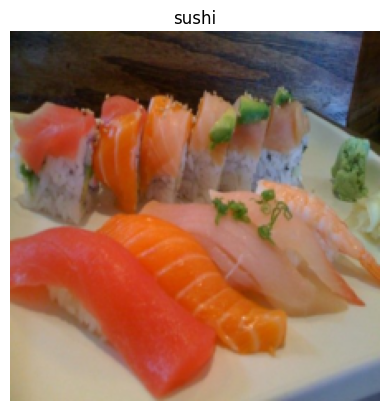

In [19]:
# Plot image with matplotlib

plt.imshow(image.permute(1, 2, 0)) # [color_channels, height, width] -> [height, width, color_channel]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT

Lookin at the whole machine learning reserach paper can be imtimidating

So in order to make it more understandable, we can break it down into smaller pieces

* **Inputs** - what goes into the model (in our case, image tensors)
* **Outputs** - what comes out of the model (in our case, we want the model to output image classification label)
* **Layers** - takes an input, manipulates it wuth a functino (for example could be self-attention)
* **Blocks** - collection of layers
* **Model (or architecture)** - collection of blocks

### 3.1 ViT overview

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functinos of each layer / block
* Table 1/3: different hyperparameteres for the architecture / training